<a href="https://colab.research.google.com/github/romenlaw/NaiveNeuralNetwork/blob/main/visualise-loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

From article https://towardsdatascience.com/whats-inside-a-neural-network-799daf235463

In [131]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from tqdm import tqdm
import time
from collections import OrderedDict
import warnings

warnings.filterwarnings('ignore')

# Prepare Dataset

The dataset:
$y=\begin{cases}
2x+5, x<-2 \\
7.3 \sin(x), -2\le x<2 \\
-0.03x^3+2, x \ge 2
\end{cases}
$

In [132]:
np.random.seed(42)
X = np.random.normal(1, 4.5, 10000)
y = np.piecewise(
    X,
     [X < -2,(X >= -2) & (X < 2), X >= 2],
      [lambda X: 2*X + 5, lambda X: 7.3*np.sin(X), lambda X: -0.03*X**3 + 2]
    ) + np.random.normal(0, 1, X.shape)

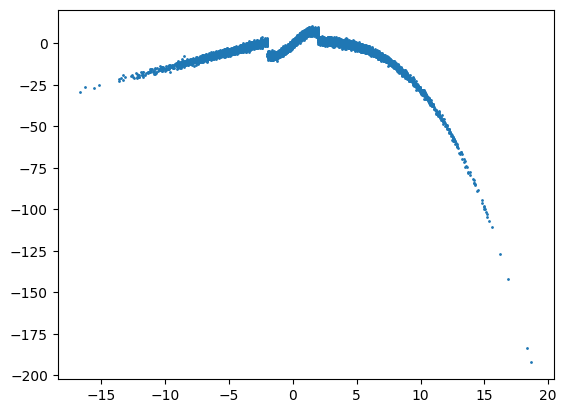

In [133]:
plt.scatter(X, y, s=1)

see also https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [134]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, Y):
    self.x = torch.tensor(X)
    self.y = torch.tensor(Y)
    self.len = self.x.shape[0]

  def __len__(self):
    return self.len

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

see also https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [136]:
batch_size = 128
train = Dataset(X_train.astype(np.float32), y_train.astype(np.float32))
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size)

test = Dataset(X_test.astype(np.float32), y_test.astype(np.float32))
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size)

In [137]:
train_loader.dataset.len, test_loader.dataset.len, len(train_loader), len(test_loader)

(7000, 3000, 55, 24)

In [138]:
55*128, 24*128, 63*128, 16*128

(7040, 3072, 8064, 2048)

In [139]:
i=0
for a, b in train_loader:
  if i==0:
    print(a.shape, a)
    print(b.shape, b)
  i+=1
i

torch.Size([128]) tensor([ 4.2617, -4.3535,  1.9450, -2.6461,  0.3767, -5.1019, -4.0021,  3.3150,
        -1.6545, -4.7126,  0.5339,  3.2777, -4.5280,  5.5516,  2.4006,  3.6997,
         5.3052,  2.1902,  0.8333, -4.1450, -5.0826,  2.3386,  4.3746,  2.3305,
        -6.3527,  1.1689,  1.1475, -1.4366, -7.9926, -2.8350, -1.3873,  3.1095,
         6.4546,  4.2934, -0.6349, -0.3745,  2.9635,  0.8205,  5.1761, -1.2000,
         6.4537,  0.6283, 10.2242,  5.3765, -4.2568,  4.4529,  1.9566,  8.5106,
         3.2702, -7.0690,  0.7181, -1.3440, -1.8070, 10.3056,  9.7082,  3.4223,
        -2.2273,  1.7899,  4.4671,  3.2400,  5.4221, -0.2696,  1.6982,  2.8168,
         3.0737, -0.9210, -0.0558,  9.7459, -2.6489,  0.4888, -2.3367,  8.6685,
         1.3591,  5.1802,  4.9490,  6.5360, -1.0616,  1.6931, -5.8839, -2.3084,
         1.4689,  2.7323,  0.9750, -7.6009,  7.5888,  2.9437,  6.2383, -7.5710,
         3.2537,  3.0305,  0.3192, -0.9937,  1.8635,  6.9769,  2.0309, -0.4224,
         4.1654,  5.02

55

In [140]:
a.reshape((-1, 1)).shape, a.unsqueeze(-1).shape

(torch.Size([88, 1]), torch.Size([88, 1]))

# Neural Network

In [141]:
# a toy NN
class ANN(nn.Module):
  def __init__(self, in_features=128, hidden_dim=128, out_features=1):
    super().__init__()
    self.net = nn.Sequential(OrderedDict({
        "Layer_1": nn.Linear(in_features, hidden_dim, bias=False),
        "tahn": nn.Tanh(),
        "Layer_2": nn.Linear(hidden_dim, out_features, bias=False)
    }))

  def forward(self, x):
    """x is in dimension of (batch_size, in_features)
    """
    return self.net(x)

In [142]:
model = ANN(1, 1, 1)
loss = nn.MSELoss()
model

ANN(
  (net): Sequential(
    (Layer_1): Linear(in_features=1, out_features=1, bias=False)
    (tahn): Tanh()
    (Layer_2): Linear(in_features=1, out_features=1, bias=False)
  )
)

In [143]:
for name, param in model.named_parameters():
  print(name, param.shape)
  print(param)

net.Layer_1.weight torch.Size([1, 1])
Parameter containing:
tensor([[0.1628]], requires_grad=True)
net.Layer_2.weight torch.Size([1, 1])
Parameter containing:
tensor([[0.3517]], requires_grad=True)


In [144]:
model.net._modules['Layer_1'].weight, model.net._modules['Layer_1'].weight.data, model.net._modules['Layer_1'].weight.data.shape

(Parameter containing:
 tensor([[0.1628]], requires_grad=True),
 tensor([[0.1628]]),
 torch.Size([1, 1]))

# Create the grid
To build the error surface, we first need to create a grid of possible values for W1 and W2. Then, for each weight combination, we will update the parameters of the network and calculate the error:

In [145]:
W1, W2 = np.arange(-2, 2, 0.05), np.arange(-2, 2, 0.05)
LOSS = np.zeros((len(W1), len(W2)))
W1.shape, W2.shape, LOSS.shape, len(W1)

((80,), (80,), (80, 80), 80)

In [146]:
for i, w1 in enumerate(W1):
  model.net._modules['Layer_1'].weight.data = torch.tensor([[w1]], dtype=torch.float32)

  for j, w2 in enumerate(W2):
    model.net._modules['Layer_2'].weight.data = torch.tensor([[w2]], dtype=torch.float32)

    model.eval() # set model to evaluation mode (train(False))
    total_loss = 0
    with torch.no_grad():
      for x, y in test_loader:
        pred = model(x.unsqueeze(-1)) # dim is batch_size, in_feature
        total_loss += loss(pred, y).item()

    LOSS[i,j]=total_loss / len(test_loader)

In [107]:
import plotly.graph_objects as go
import plotly.io as pio

plotly_template = pio.templates["plotly_dark"]
fig = go.Figure(data=[go.Surface(z=LOSS, x=W1, y=W2)])

# Update the layout
fig.update_layout(
    title='Loss Surface',
    scene=dict(
        xaxis_title='w1',
        yaxis_title='w2',
        zaxis_title='Loss',
        aspectmode='manual',
        aspectratio=dict(x=1, y=1, z=0.5),
        xaxis=dict(showgrid=False),
        yaxis=dict(showgrid=False),
        zaxis=dict(showgrid=False),
    ),
    width=800,
    height=800
)

fig.show()

# Training

Our grid resolution is 0.05 - anything smaller than 0.05 cannot be displayed on the plot. So set the learning rate of training between 0.1 and 0.01.

In [169]:
model = ANN(1,1,1)
lr = 1e-2
epochs = 25
optimiser = optim.SGD(model.parameters(), lr)
errors, weights_1, weights_2 = [], [], []

model.net._modules['Layer_1'].weight.data = torch.tensor([[-1]], dtype=torch.float32)
model.net._modules['Layer_2'].weight.data = torch.tensor([[-1]], dtype=torch.float32)

In [170]:
model

ANN(
  (net): Sequential(
    (Layer_1): Linear(in_features=1, out_features=1, bias=False)
    (tahn): Tanh()
    (Layer_2): Linear(in_features=1, out_features=1, bias=False)
  )
)

In [171]:
for name, param in model.named_parameters():
  print(name, param.shape)
  print(param)

net.Layer_1.weight torch.Size([1, 1])
Parameter containing:
tensor([[-1.]], requires_grad=True)
net.Layer_2.weight torch.Size([1, 1])
Parameter containing:
tensor([[-1.]], requires_grad=True)


In [172]:
model.eval()
with torch.no_grad():
  total_loss = 0
  for x, y in test_loader:
    preds = model(torch.unsqueeze(x, -1))
    total_loss += loss(preds, y).item()

weights_1.append(model.net._modules['Layer_1'].weight.data.item())
weights_2.append(model.net._modules['Layer_2'].weight.data.item())
errors.append(total_loss / len(test_loader)) # len(loader) is really the number of batches

This is the starting point of the gradient descent, i.e. before training.

In [173]:
errors, weights_1, weights_2

([114.01608268419902], [-1.0], [-1.0])

In [174]:
for epoch in tqdm(range(epochs)):
  model.train() # put model in training mode

  for x, y in train_loader:
    logits = model(x.unsqueeze(-1))
    error = loss(logits, y)
    optimiser.zero_grad()
    error.backward()
    optimiser.step()

  model.eval()
  #correct, total = 0.0, 0.0
  with torch.no_grad():
    total_loss = 0
    for x, y in test_loader:
      preds = model(x.unsqueeze(-1)) # (batch_size, in_features)
      total_loss += loss(preds, y).item()

      # correct += (preds.squeeze() == y).sum().item()
      # total += y.size(0)

  #print(f"test accuracy: {correct/total*100}")
  weights_1.append(model.net._modules['Layer_1'].weight.data.item())
  weights_2.append(model.net._modules['Layer_2'].weight.data.item())
  errors.append(total_loss / len(test_loader))


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


In [175]:
preds.shape, y.size(0)

(torch.Size([56, 1]), 56)

# Visualise

In [176]:
import plotly.graph_objects as go
import plotly.io as pio

plotly_template = pio.templates["plotly_dark"]
fig = go.Figure(data=[go.Surface(z=LOSS, x=W1, y=W2)])

# Update the layout
fig.update_layout(
    title='Loss Surface',
    scene=dict(
        xaxis_title='w1',
        yaxis_title='w2',
        zaxis_title='Loss',
        aspectmode='manual',
        aspectratio=dict(x=1, y=1, z=0.5),
        xaxis=dict(showgrid=False),
        yaxis=dict(showgrid=False),
        zaxis=dict(showgrid=False),
    ),
    width=800,
    height=800
)
fig.add_trace(go.Scatter3d(x=weights_2, y=weights_1, z=errors,
                               mode='lines+markers',
                              line=dict(color='red', width=2),
                              marker=dict(size=4, color='yellow') ))
fig.show()

# Visualise Optimizers

In [245]:
def create_and_train(opt="SGD", lr=0.01):
  model = ANN(1,1,1)
  optimiser = None
  if opt=='Adam':
    optimiser = optim.Adam(model.parameters(), lr=lr) #, amsgrad=True)
  elif opt == 'RMSprop':
    optimiser = optim.RMSprop(model.parameters(), lr=lr)
  elif opt == 'Rprop':
    optimiser = optim.Rprop(model.parameters(), lr=lr) #, maximize=True)
  else:
    optimiser = optim.SGD(model.parameters(), lr=lr) #, momentum=0.9, nesterov=True)

  errors, weights_1, weights_2 = [], [], []

  model.net._modules['Layer_1'].weight.data = torch.tensor([[-1]], dtype=torch.float32)
  model.net._modules['Layer_2'].weight.data = torch.tensor([[-1]], dtype=torch.float32)

  # starting point of gradient decent
  model.eval()
  with torch.no_grad():
    total_loss = 0
    for x, y in test_loader:
      preds = model(torch.unsqueeze(x, -1))
      total_loss += loss(preds, y).item()

  weights_1.append(model.net._modules['Layer_1'].weight.data.item())
  weights_2.append(model.net._modules['Layer_2'].weight.data.item())
  errors.append(total_loss / len(test_loader)) # len(loader) is really the number of batches

  # training loop
  for epoch in tqdm(range(epochs)):
    model.train() # put model in training mode

    for x, y in train_loader:
      logits = model(x.unsqueeze(-1))
      error = loss(logits, y)
      optimiser.zero_grad()
      error.backward()
      optimiser.step()

    model.eval()
    #correct, total = 0.0, 0.0
    with torch.no_grad():
      total_loss = 0
      for x, y in test_loader:
        preds = model(x.unsqueeze(-1)) # (batch_size, in_features)
        total_loss += loss(preds, y).item()

        # correct += (preds.squeeze() == y).sum().item()
        # total += y.size(0)

    #print(f"test accuracy: {correct/total*100}")
    weights_1.append(model.net._modules['Layer_1'].weight.data.item())
    weights_2.append(model.net._modules['Layer_2'].weight.data.item())
    errors.append(total_loss / len(test_loader))

  return errors, weights_1, weights_2

In [246]:
SGD_err, SGD_w1, SGD_w2 = create_and_train("SGD")
Adam_err, Adam_w1, Adam_w2 = create_and_train("Adam")
RMSp_err, RMSp_w1, RMSp_w2 = create_and_train("RMSprop")
Rp_err, Rp_w1, Rp_w2 = create_and_train("Rprop")

100%|██████████| 25/25 [00:03<00:00,  6.35it/s]


In [247]:
import plotly.graph_objects as go
import plotly.io as pio

plotly_template = pio.templates["plotly_dark"]
fig = go.Figure(data=[go.Surface(z=LOSS, x=W1, y=W2)])

# Update the layout
fig.update_layout(
    title='Loss Surface',
    scene=dict(
        xaxis_title='w1',
        yaxis_title='w2',
        zaxis_title='Loss',
        aspectmode='manual',
        aspectratio=dict(x=1, y=1, z=0.5),
        xaxis=dict(showgrid=False),
        yaxis=dict(showgrid=False),
        zaxis=dict(showgrid=False),
    ),
    width=800,
    height=800
)
fig.add_trace(go.Scatter3d(x=Rp_w2, y=Rp_w1, z=Rp_err,
                               mode='lines+markers',
                              line=dict(color='magenta', width=2),
                              marker=dict(size=4, color='magenta') ))
fig.add_trace(go.Scatter3d(x=SGD_w2, y=SGD_w1, z=SGD_err,
                               mode='lines+markers',
                              line=dict(color='yellow', width=2),
                              marker=dict(size=4, color='yellow') ))
fig.add_trace(go.Scatter3d(x=Adam_w2, y=Adam_w1, z=Adam_err,
                               mode='lines+markers',
                              line=dict(color='cyan', width=2),
                              marker=dict(size=4, color='cyan') ))
fig.add_trace(go.Scatter3d(x=RMSp_w2, y=RMSp_w1, z=RMSp_err,
                               mode='lines+markers',
                              line=dict(color='pink', width=2),
                              marker=dict(size=4, color='pink') ))

fig.show()